# <a id='toc1_'></a>[Rusty Bargain](#toc0_)
El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

**Table of contents**<a id='toc0_'></a>    
- [Rusty Bargain](#toc1_)    
  - [Inicialización](#toc1_1_)    
  - [Preparación de datos](#toc1_2_)    
  - [Preprocesamiento de datos](#toc1_3_)    
    - [Análisis de nulos](#toc1_3_1_)    
    - [Análisis de duplicados](#toc1_3_2_)    
    - [Análisis de `price`](#toc1_3_3_)    
    - [Análisis de `RegistrationMonth`](#toc1_3_4_)    
    - [Análisis de `Power`](#toc1_3_5_)    
    - [Análisis de `RegistrationYear`](#toc1_3_6_)    
    - [Limpieza de calidad](#toc1_3_7_)    
    - [Separación en dataframes específicos](#toc1_3_8_)    
  - [Entrenamiento del modelo](#toc1_4_)    
    - [Modelo _dummy_ (Regresion Lineal)](#toc1_4_1_)    
    - [Modelo de bosques aleatorios](#toc1_4_2_)    
    - [LightGBM](#toc1_4_3_)    
    - [CatBoost](#toc1_4_4_)    
  - [Análisis del modelo](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Inicialización](#toc0_)

In [1]:
# Primero cargamos las librerias principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# De ahi herramientas para entrenar y evaluar los modelos
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Finalmente los modelos en cuestion
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as gbm
import xgboost as xgb

## <a id='toc1_2_'></a>[Preparación de datos](#toc0_)

In [2]:
# Carguemos los datos en una variable
df = pd.read_csv('../../data/raw/car_data.csv')

In [3]:
# Primero realizamos una revisión inicial de los datos
df.info()
display(df.describe())
df.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18


Vayamos de arriba hacia abajo. En el info podemos notar que hay una cierta prescencia de nulos que ahondaremos más adelante y podemos notar que los _dtypes_ de las columnas parecen coherentes.
  
Los problemas aparecen cuando vemos _describe_. `Price, Power y RegistrationMonth` parece empezar en 0 y `RegistrationYear` empieza en 1000. No soy ningún mecánico pero creo que no pueden haber autos ni vendedores con esos números (y ni hablemos de que la columna `NumberOfPictures` es básicamente una columna inútil).

In [4]:
# Nos saquemos NumberOfPictures de encima directamente
df.drop(columns='NumberOfPictures', inplace=True)

## <a id='toc1_3_'></a>[Preprocesamiento de datos](#toc0_)

### <a id='toc1_3_1_'></a>[Análisis de nulos](#toc0_)

In [5]:
# Ahora evaluemos la cantidad de valores nulos presentes por columna
df.isna().mean().sort_values(ascending= False)*100

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Mileage               0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Al parecer nos encontramos con la presencia de multiples nulos. En sí no es un problema ya que los modelos que planeamos usar tiene formas de manejar los nulos, casi todos los modelos. Nuestro _dummy_ será un modelo de regresión lineal y ese tipo de modelos si tiene problemas con los nulos. Para eso creemos un df separado sobre el que vamos a trabajar.
  
De todas formas hay que ver un poco más los nulos ya que nos ayuda a echar un vistazo sobre los datos en el proceso.

In [6]:
# Veamos cuántas filas del total contienen nulos
df.isna().any(axis=1).mean()*100

30.633322892239445

In [7]:
# Con casi un 30% tendremos que ver en más detalle
df[df.isna().any(axis=1)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,27472,31/03/2016 17:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354357,09/03/2016 11:36,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,09/03/2016 00:00,18246,04/04/2016 08:15
354361,09/03/2016 13:37,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,51371,13/03/2016 01:44
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,39576,06/04/2016 00:46


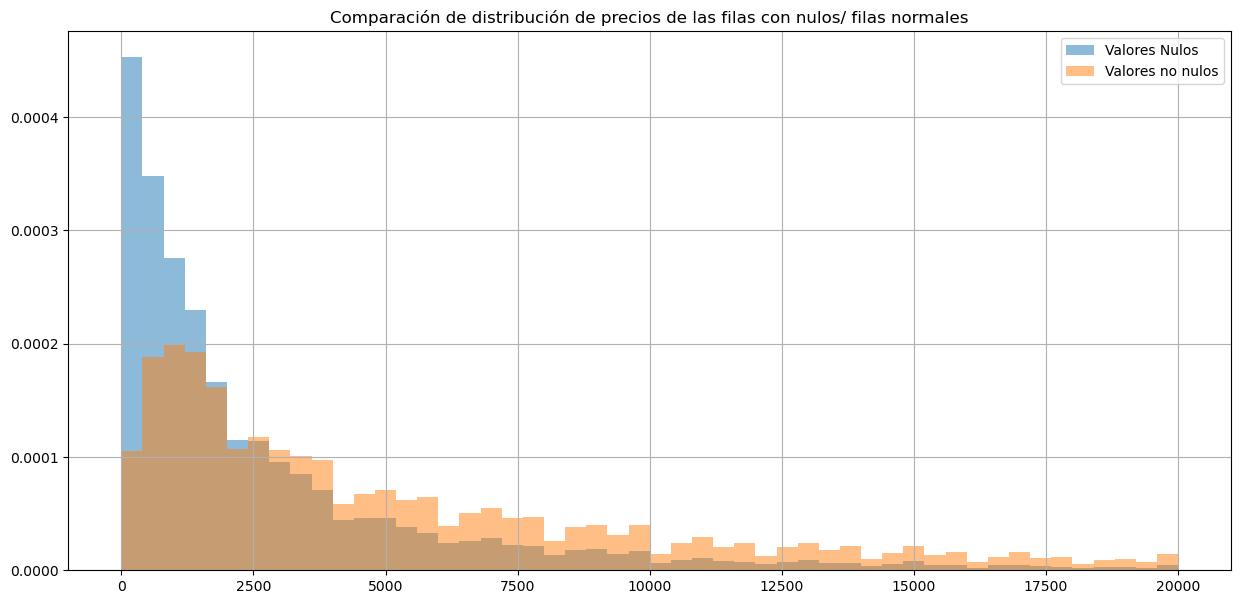

In [8]:
# Y como se distribuye el target a comparacion del df original?

# Primero dejemos el gráfico con un buen tamaño y un titulo
plt.figure(figsize=(15,7))
plt.title('Comparación de distribución de precios de las filas con nulos/ filas normales')

# De ahi graficamos ambos histogramas en base a la densidad para "saltearnos" la diferencia numérica de ambos
df[df.isna().any(axis=1)]['Price'].hist(bins=50,alpha=0.5,label='Valores Nulos', density=True)
df[~df.isna().any(axis=1)]['Price'].hist(bins=50,alpha=0.5,label='Valores no nulos', density=True)

# De ahi aplicamos la leyenda y el .show()
plt.legend()
plt.show()

Interesante, por lo que podemos ver hay una gran concentración de valores bajos con nulos presentes, e incluso vemos que es ~4 veces más común encontrar valores cercanos a 0 si ésta fila tiene un valor nulo. Tambien podemos ver que no están únicamente concentrados en los valores bajos!
  
Pasemos al siguiente paso.

### <a id='toc1_3_2_'></a>[Análisis de duplicados](#toc0_)

In [9]:
# Ahora revisemos por duplicados
df.duplicated().sum()

262

In [10]:
# Veamos en más detalle los duplicados en cuestión
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,65529,05/04/2016 20:47
27568,23/03/2016 10:38,12200,bus,2011,manual,125,zafira,40000,10,gasoline,opel,no,23/03/2016 00:00,26629,05/04/2016 07:44
31599,03/04/2016 20:41,4950,wagon,2003,auto,170,e_klasse,150000,4,gasoline,mercedes_benz,no,03/04/2016 00:00,48432,05/04/2016 21:17
33138,07/03/2016 20:45,10900,convertible,2005,auto,163,clk,125000,5,petrol,mercedes_benz,no,07/03/2016 00:00,61200,21/03/2016 03:45
43656,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,14482,13/03/2016 20:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349709,03/04/2016 20:52,700,small,1999,manual,60,ibiza,150000,12,petrol,seat,yes,03/04/2016 00:00,6268,05/04/2016 21:47
351555,26/03/2016 16:54,3150,bus,2003,manual,86,transit,150000,11,gasoline,ford,no,26/03/2016 00:00,96148,02/04/2016 07:47
352384,15/03/2016 21:54,5900,wagon,2006,manual,129,3er,150000,12,petrol,bmw,no,15/03/2016 00:00,92526,20/03/2016 21:17
353057,05/03/2016 14:16,9500,small,2013,manual,105,ibiza,40000,5,petrol,seat,no,04/03/2016 00:00,61381,05/04/2016 19:18


In [11]:
# Ya que no se ve un patrón evidente y no son tantas filas vamos a descartar los duplicados sin problemas
df.drop_duplicates(inplace=True)

Nulos y duplicados listos, ahora vamos a ver esos valores extraños que observamos previamente. Primero veamos respecto a nuestro qurido target.

### <a id='toc1_3_3_'></a>[Análisis de `price`](#toc0_)

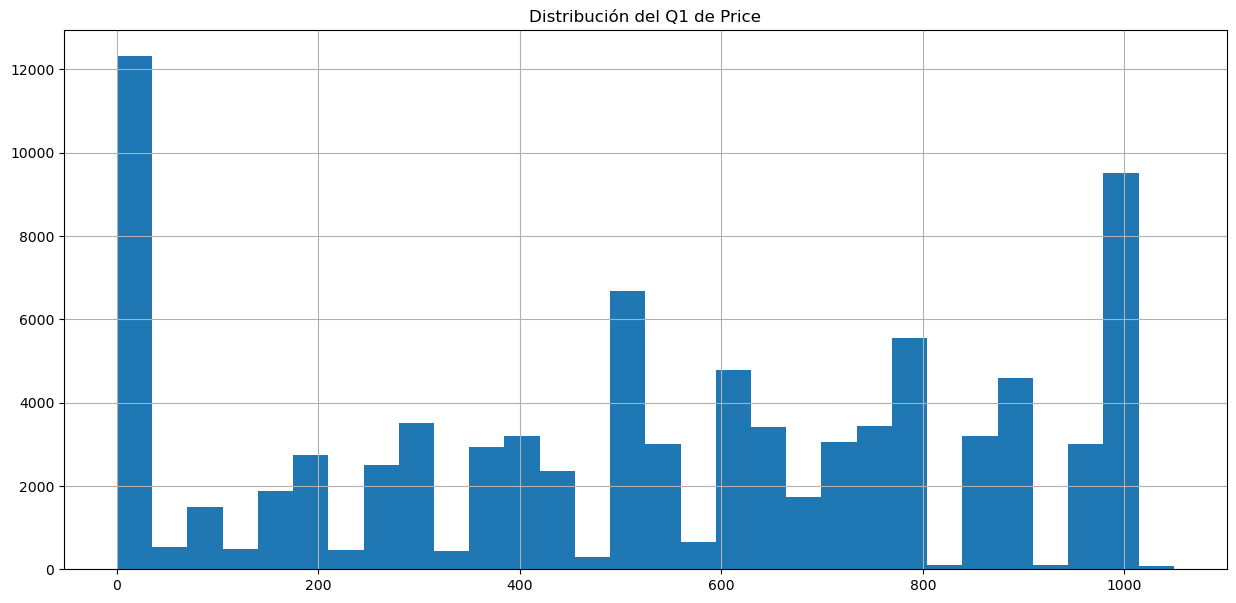

In [12]:
# Veamos el primer cuarto de los valores de Price
plt.figure(figsize=(15,7))
df[df['Price'] < 1050]['Price'].hist(bins=30)
plt.title('Distribución del Q1 de Price')
plt.show()

Podemos notar como hay una gran concentración de valores en el rango de (0,20). Creer que alguien está vendiendo un auto a un precio tan bajo me hace creer que no fue más que un error en la carga o que pusieron un precio extremadamente bajo a modo de esconder el verdadero precio que pedían por el vehículo. Más allá del motivo, vamos a tener que eliminar esos valores.

In [13]:
# Sin más vueltas, eliminemos esos valores con precio menor a 20
df = df.drop(index=list(df[df['Price'] < 20].index))

In [14]:
# Veamos entonces como quedó nuestro df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341933 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        341933 non-null  object
 1   Price              341933 non-null  int64 
 2   VehicleType        308788 non-null  object
 3   RegistrationYear   341933 non-null  int64 
 4   Gearbox            325088 non-null  object
 5   Power              341933 non-null  int64 
 6   Model              324719 non-null  object
 7   Mileage            341933 non-null  int64 
 8   RegistrationMonth  341933 non-null  int64 
 9   FuelType           313047 non-null  object
 10  Brand              341933 non-null  object
 11  NotRepaired        276870 non-null  object
 12  DateCreated        341933 non-null  object
 13  PostalCode         341933 non-null  int64 
 14  LastSeen           341933 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.7+ MB


### <a id='toc1_3_4_'></a>[Análisis de `RegistrationMonth`](#toc0_)
Ahora avanzamos sobre las siguientes columnas con valores... extraños. En éste caso le toca a `RegistrationMonth`, particularmente a los valores con mes 0.

In [15]:
df[df['RegistrationMonth'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,27472,31/03/2016 17:17
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,24148,19/03/2016 08:46
16,01/04/2016 12:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,38871,01/04/2016 12:46
36,11/03/2016 11:50,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,11/03/2016 00:00,2943,07/04/2016 03:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,03/04/2016 13:46,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,03/04/2016 00:00,74579,05/04/2016 12:44
354318,15/03/2016 19:57,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN,15/03/2016 00:00,24558,19/03/2016 15:49
354326,31/03/2016 19:36,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,31/03/2016 00:00,35102,06/04/2016 13:44
354329,30/03/2016 20:55,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,30/03/2016 00:00,25436,07/04/2016 13:50


In [16]:
# Me llama mucho la atención los NotRepaired, cuántos serán?
df[df['RegistrationMonth'] == 0]['NotRepaired'].isna().sum()

18610

In [17]:
# Veamos de vuelta cuántos teníamos en el df original
df[df['NotRepaired'].isna()].shape[0]

65063

In [18]:
# Un describe no nos vendría mal
df[df['RegistrationMonth'] == 0].describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
count,32236.000000,32236.000000,32236.000000,32236.00000,32236.0,32236.000000
mean,2210.569270,2009.723198,73.249007,130298.88944,0.0,48005.427876
std,2897.407697,231.853625,251.834365,41723.10254,0.0,25855.236613
min,20.000000,1000.000000,0.000000,5000.00000,0.0,1067.000000
25%,500.000000,1997.000000,0.000000,150000.00000,0.0,26954.000000
50%,1150.000000,2000.000000,60.000000,150000.00000,0.0,46397.000000
75%,2600.000000,2006.000000,114.000000,150000.00000,0.0,66583.000000
max,20000.000000,9999.000000,19211.000000,150000.00000,0.0,99998.000000


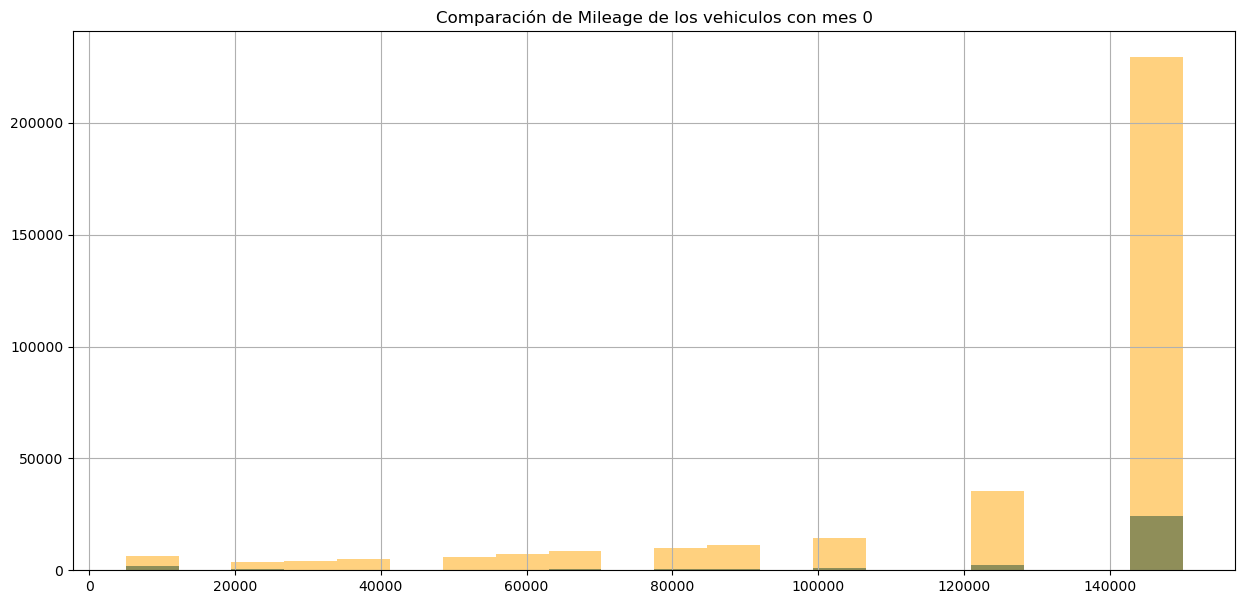

In [19]:
plt.figure(figsize=(15,7))
df[df['RegistrationMonth'] == 0]['Mileage'].hist(bins=20)
df['Mileage'].hist(bins=20, alpha= 0.5, color='orange')
plt.title('Comparación de Mileage de los vehiculos con mes 0')
plt.show()

In [20]:
# No veo nada llamativo en Mileage, pero parece haber un patron con DateCreated y LastSeen
# Primero tenemos que convertir las columnas en datetime
df['DateCreated'] = pd.to_datetime(df['DateCreated'],format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'],format='%d/%m/%Y %H:%M')
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'],format='%d/%m/%Y %H:%M')

In [21]:
# Verifiquemos si todas las columnas se hicieron a las 00 horas o puede ser un patrón en DateCreated
(df['DateCreated'].dt.hour != 0).sum()

0

Mi hipótesis es que en todo el proceso de que los datos lleguen a nosotros se perdió la hora de `DateCreated` y posteriormente se imputaron automáticamente como 00 horas.

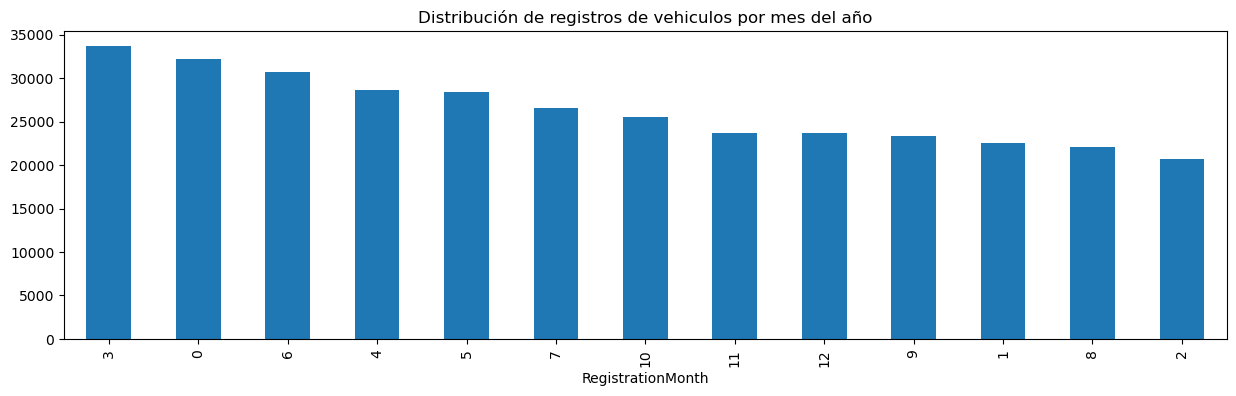

In [22]:
# Ahora revisemos si podemos ver algo interesante con un gráfico de barras
plt.figure(figsize=(15,4))
df['RegistrationMonth'].value_counts().plot(kind='bar')
plt.title('Distribución de registros de vehiculos por mes del año')
plt.show()

Con éste gráfico nos encontramos con una situación problemática... Vemos como el grupo con el mes 0 representa el conjunto más grande de todos. Reemplazarlos por nulos es una opción parcialmente válida ya que tenemos 2 modelos que permiten la presencia de nulos (LightGBM y CatBooster) y los otros dos (Regresión lineal y RandomForest de sklearn) no permiten y les estaríamos eliminando el grupo mas grande de los datos. Para concluir quiero ver cuántas columnas tienen `RegistrationMonth` = 0 y nulos en alguna columna.

In [23]:
100 * df[df['RegistrationMonth'] == 0].isna().any(axis=1).sum() / df[df['RegistrationMonth'] == 0].shape[0]

78.88695867973694

In [24]:
# Okay, al parecer el 80% de las filas tienen nulos de todas formas. Entonces realicemos el reemplazo sin drama
df['RegistrationMonth'] = df['RegistrationMonth'].astype(float).replace(to_replace=0,value=np.nan)

In [25]:
# Y verifiquemos cuántos valores son nulos nos quedaron en la columna
df['RegistrationMonth'].isna().mean()

0.09427577917311286

### <a id='toc1_3_5_'></a>[Análisis de `Power`](#toc0_)

In [26]:
# Veamos entonces cuántos datos cubren esos autos sin potencia
print(f' Cantidad de vehículos con potencia 0: { (df[df["Power"] == 0].shape[0])}',
 f'\n Proporción respecto al total: {(df["Power"] == 0).mean()}')

 Cantidad de vehículos con potencia 0: 35720 
 Proporción respecto al total: 0.10446490979226924


Para éste caso voy a realizar un reemplazo muy especial. Voy a reemplazar los valores de potencia tomando dos referencias: `Brand` y `Model`.

In [37]:
# Primero creamos una tabla de la cual vamos a obtener nuestros valores reemplazo
power_replace_table = df.groupby(['Brand','Model'],dropna=False).mean(numeric_only=True)

In [38]:
# Vamos a hacer una función que utilice .apply()
def input_power(row):
    
    # Antes que nada verificamos que Power no sea 0 y si no es, devolvemos la fila como está
    if row['Power'] != 0:
        return row
    
    # Guardamos los valores pertinentes en variables
    filled_row = row.copy()
    brand = row['Brand']
    model = row['Model']
    
    # Ahora verificamos primero si Model es nulo, de ser así reemplazamos con la media de su marca
    if pd.isnull(model):
        filled_row['Power'] = power_replace_table['Power'][brand].mean()
        
    # Si ese no es el caso, reemplazamos con la media del modelo en cuestión
    else:
        filled_row['Power'] = power_replace_table['Power'][brand][model]
        
    # Finalmente devolvemos la fila con el valor imputado
    return filled_row

In [40]:
%%time
# Ahora reemplazamos nuestro df con los valores imputados y los transformamos de vuelta a int redondeado para abajo
df = (df.apply(input_power, axis=1)).astype({'Power':int})

CPU times: total: 15.5 s
Wall time: 15.4 s


### <a id='toc1_3_6_'></a>[Análisis de `RegistrationYear`](#toc0_)
Pasamos a la última etapa compleja del preprocesamiento de datos!

In [41]:
df[df['RegistrationYear'] < 1900]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
16062,2016-03-29 23:42:00,190,NaN,1000,NaN,116,mondeo,5000,NaN,NaN,ford,NaN,2016-03-29,47166,2016-04-06 10:44:00
18224,2016-03-09 17:49:00,7999,NaN,1500,manual,224,impreza,5000,3.0,NaN,subaru,NaN,2016-03-09,53577,2016-03-15 05:15:00
34332,2016-04-01 06:02:00,450,NaN,1800,NaN,1800,NaN,5000,2.0,NaN,mitsubishi,no,2016-04-01,63322,2016-04-01 09:42:00
38875,2016-03-19 23:54:00,1234,NaN,1234,NaN,26,NaN,5000,1.0,NaN,trabant,NaN,2016-03-19,38518,2016-04-06 03:15:00
53577,2016-03-20 11:44:00,330,NaN,1000,NaN,63,polo,5000,NaN,NaN,volkswagen,NaN,2016-03-20,45259,2016-04-04 08:17:00
55605,2016-03-10 19:50:00,500,NaN,1000,NaN,88,NaN,5000,NaN,NaN,citroen,yes,2016-03-10,24811,2016-04-06 03:45:00
56241,2016-03-30 18:54:00,950,NaN,1400,manual,1400,golf,125000,4.0,petrol,volkswagen,NaN,2016-03-30,50389,2016-04-03 09:45:00
60017,2016-03-10 12:38:00,80,NaN,1000,NaN,113,NaN,5000,NaN,NaN,volkswagen,NaN,2016-03-10,93107,2016-04-07 04:45:00
66198,2016-03-08 14:50:00,1300,NaN,1000,auto,106,NaN,5000,6.0,petrol,sonstige_autos,NaN,2016-03-08,13156,2016-03-17 08:17:00
70847,2016-03-28 18:57:00,100,NaN,1255,NaN,106,NaN,5000,NaN,NaN,sonstige_autos,NaN,2016-03-28,59069,2016-04-07 01:16:00


Por los que vemos, hay mucha gente que no pone el esfuerzo siquiera de agregar el año correcto de su vehículo y lo rellenan con lo que sea. Dado que el año de un vehículo sí es importante en su precio y que no son tantas filas las que conformas los "usuarios vagos" vamos a eliminarlas sin más!

In [42]:
# Igual que como hicimos con los precios anormalmente bajos
df = df.drop(index=list(df[df['RegistrationYear'] < 1900].index))

### <a id='toc1_3_7_'></a>[Limpieza de calidad](#toc0_)
Ver la tabla anterior me hizo pensar sobre que utilidad tiene una fila con demasiados valores nulos. Pero, donde ponemos el límite? Es muy simple, vamos a usar 11 filas de las que tenemos en nuestro df para entrenar los modelos. Voy a colocar el número límite en 4 filas con nulos: Si una fila tiene 4 filas con nulos o más la eliminaremos!
  
Por que 4 filas? Ese número me da la certeza de que todas las filas que tengo en el dataframe son más del 65% información útil.
  
Por supuesto, no voy a eliminarlas así nomas, primero me voy a fijar que cantidad de filas representan.

In [43]:
print('Filas totales:',df.shape[0])
print('Filas impuras:',(df.isna().sum(axis=1) >= 4).sum())
print('Filas restantes:',(df.isna().sum(axis=1) < 4).sum())

Filas totales: 341884
Filas impuras: 9508
Filas restantes: 332376


In [44]:
# Dado que las filas no llegan a representar ni el 3% del df, vamos a eliminarlas y proceder
df = df.drop(index=list(df[df.isna().sum(axis=1) >= 4].index))

### <a id='toc1_3_8_'></a>[Separación en dataframes específicos](#toc0_)

In [45]:
# Vamos a hacer un un df apto para el modelo dummy (regresión lineal)
lr_df = df.dropna(how='any')

In [46]:
# Otra cosa que vamos a preparar es un df para LightGBM
# Primero pasamos las features categoricas a category
gbm_df = (df.astype({
    'VehicleType':'category',
    'Gearbox':'category',
    'Model':'category',
    'FuelType':'category',
    'Brand':'category',
    'PostalCode':'category',
    'NotRepaired':'category',
    'RegistrationYear':'category',
    'RegistrationMonth':'category'
}))

# De ahi guardamos dichas columnas
cat_columns = gbm_df.select_dtypes(include='category').columns

# Finalmente transformamos las columnas en int así GBM puede interpretarlas
gbm_df[cat_columns] = gbm_df[cat_columns].apply(lambda x: x.cat.codes)

## <a id='toc1_4_'></a>[Entrenamiento del modelo](#toc0_)

Antes de entrenar cualquier modelo vamos a definir las columnas que conforman las _features_ y la que conforma _target_.

In [47]:
feature_columns = ['VehicleType','RegistrationYear','Gearbox','Power','Model','Mileage',
                   'RegistrationMonth','FuelType','Brand','NotRepaired']
target_column = ['Price']

In [48]:
# Definamos tambien las tablas con los datos nulos
features = df[feature_columns]
target = df[target_column]

In [49]:
# Y separemos los conjuntos de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=41859)

### <a id='toc1_4_1_'></a>[Modelo _dummy_ (Regresion Lineal)](#toc0_)

Ahora si vamos a comenzar con el _dummy model_ basado en regresión lineal. Para eso utilizaremos el dataframe sin nulos ya que la regresión lineal no acepta valores ausentes.

In [50]:
dummy_features = pd.get_dummies(lr_df[feature_columns],columns=np.delete(feature_columns,[3,5]))
dummy_target = lr_df[target_column]

In [51]:
# Separamos los datos
dummy_features_train, dummy_features_test, dummy_target_train, dummy_target_test = train_test_split(
    dummy_features, dummy_target, test_size=0.25, random_state=41859)

In [52]:
# Cargamos el modelo
dummy_model = LinearRegression()

In [53]:
%%time
# Entrenamos el modelo
dummy_model.fit(dummy_features_train, dummy_target_train)

CPU times: total: 19.2 s
Wall time: 5.16 s


LinearRegression()

In [54]:
%%time
# Finalmente guardamos sus predicciones
dummy_predictions_train = dummy_model.predict(dummy_features_train)
dummy_predictions_test = dummy_model.predict(dummy_features_test)

CPU times: total: 1.31 s
Wall time: 1.04 s


### <a id='toc1_4_2_'></a>[Modelo de bosques aleatorios](#toc0_)
  


In [55]:
# Primero vamos a realizar una optimización de hiperparámetros con la ayuda de una funcion
forest_search = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions = {
        'n_estimators': np.arange(10,30),
        'max_depth': np.arange(3,9),
        'min_samples_split': np.arange(500,2000)
    },
    n_iter = 5,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    random_state = 85963,
    verbose=1)

In [56]:
%%time
# Como el RandomForest de sklearn no tolera nulos vamos a usar los datos dummy
forest_search.fit(dummy_features_train.values, dummy_target_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 16min 36s
Wall time: 16min 36s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8]),
                                        'min_samples_split': array([ 500,  501,  502, ..., 1997, 1998, 1999]),
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
                   random_state=85963, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [57]:
# Ahora cargamos un modelo con los parámetros obtenidos del search
forest_model = forest_search.best_estimator_

In [58]:
%%time
forest_model.fit(dummy_features_train.values, dummy_target_train.values.ravel())

CPU times: total: 48.8 s
Wall time: 48.9 s


RandomForestRegressor(max_depth=8, min_samples_split=1223, n_estimators=21)

In [59]:
%%time
forest_predictions_train = forest_model.predict(dummy_features_train)
forest_predictions_test = forest_model.predict(dummy_features_test)

c:\Users\Cruh\anaconda3\envs\TripleTen\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


CPU times: total: 547 ms
Wall time: 543 ms


c:\Users\Cruh\anaconda3\envs\TripleTen\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### <a id='toc1_4_3_'></a>[LightGBM](#toc0_)

In [65]:
# Ahora separamos los datos para GBM
gbm_features_train, gbm_features_test, gbm_target_train, gbm_target_test = train_test_split(
    gbm_df[feature_columns], gbm_df[target_column], test_size=0.25, random_state=41859)

In [66]:
# Primero definimos cuales son las columnas categóricas para LightGBM
categorical_features = [ 'VehicleType','RegistrationYear','RegistrationMonth','Gearbox','Model','FuelType','Brand','NotRepaired'] 

In [77]:
%%time
# Ahora replicaremos RandomSearch ya que los datos categóricos complican la situación al usar GBM y RandomSearchCV de sklearn
min = 99999999999999999999999 
iterations = 25

for i in range(iterations):
    # Creamos aleatoriamente los parámetros y cargamos con valores aleatorios dentro de los rangos deseados
    params = {}
    params['boosting_type'] = 'gbdt'
    params['num_leaves'] = np.random.randint(10,50)
    params['max_depth'] = np.random.randint(1,10)
    params['learning_rate'] = np.random.uniform(0.1,0.51)
    params['min_child_samples'] = np.random.randint(500,5000)
    params['colsample_bytree'] = np.random.uniform(0.1,1)
    params['early_stopping_round'] = 50
    
    # De ahi entrenamos el modelo y obtenemos sus predicciones
    gbm_model = gbm.LGBMRegressor(**params)
    gbm_model.fit(gbm_features_train, gbm_target_train, 
            feature_name= feature_columns, categorical_feature= categorical_features,
            eval_set=[(gbm_features_test,gbm_target_test)], eval_metric='rmse')
    
    target_test_pred = gbm_model.predict(gbm_features_test)
    
    # Finalmente observamos el recm
    recm = mean_squared_error(target_test_pred, gbm_target_test, squared=False)
    train_recm = mean_squared_error(gbm_model.predict(gbm_features_train), gbm_target_train, squared=False)
    
    # Y guardamos los datos si vimos un modelo mejor que el que teníamos
    if recm < min:
        min = recm
        pp = params
        tr_recm = train_recm
        
print("*" * 50)
print('RECM mínimo obtenido es:', min)
print('RECM de entrenamiento mínimo obtenido es:', tr_recm)
print('Con los parámetros:', pp)
print("*" * 50)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 249282, number of used features: 10
[LightGBM] [Info] Start training from score 4650.765438
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 2083.71	valid_0's l2: 4.34184e+06
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train se

In [ ]:
# Cargamos el mejor modelo en una variable
gbm_model = gbm.LGBMRegressor(**pp)

In [89]:
%%time
# Lo entrenamos
gbm_model.fit(gbm_features_train, gbm_target_train, 
            feature_name= feature_columns, categorical_feature= categorical_features,
            eval_set=[(gbm_features_test,gbm_target_test)], eval_metric='rmse')

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 249282, number of used features: 10
[LightGBM] [Info] Start training from score 4650.765438
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(colsample_bytree=0.7573367767398208, early_stopping_round=50,
              learning_rate=0.37959918120862024, max_depth=8,
              min_child_samples=1773, num_leaves=48)

In [90]:
%%time
# Guardamos su predicción
gbm_predictions_train = gbm_model.predict(gbm_features_train)
gbm_predictions_test = gbm_model.predict(gbm_features_test)

CPU times: total: 2.39 s
Wall time: 415 ms


### <a id='toc1_4_4_'></a>[CatBoost](#toc0_)

In [81]:
# Primero cargamos el modelo
cat_model = CatBoostRegressor(cat_features=[0,1,2,4,6,7,8,9])

In [82]:
# De ahi creamos un dict con los rangos de parámetros que vamos a explorar
cat_params = {
    'iterations':list(np.arange(10,30)),
    'learning_rate': list(np.arange(0.1,1,0.05)),
    'random_seed': [48962],
    'l2_leaf_reg': list(np.arange(2.5,7.5,0.5)),
    'depth': list(np.arange(10,20)),
    'min_data_in_leaf': list(np.arange(750,2500,150)),
    'nan_mode': ['Min','Max']
}

In [83]:
# Creamos unas nuevas variables aptas para CatBoost
cat_features_train = np.where(pd.isnull(features_train),'nan', features_train.astype({'RegistrationMonth':str}))
cat_features_test = np.where(pd.isnull(features_test),'nan', features_test.astype({'RegistrationMonth':str}))

In [84]:
%%time
# Y utilizamos el randomized search incorporado del modelo
best_random_cat_model = cat_model.randomized_search(cat_params,
                                                   X=cat_features_train, y=target_train,
                                                   cv= 7, train_size= 0.75)

0:	learn: 2991.8869869	test: 2982.9171716	best: 2982.9171716 (0)	total: 302ms	remaining: 5.73s
1:	learn: 2293.4815787	test: 2295.0486112	best: 2295.0486112 (1)	total: 461ms	remaining: 4.15s
2:	learn: 2078.3945558	test: 2096.5269516	best: 2096.5269516 (2)	total: 628ms	remaining: 3.56s
3:	learn: 1960.6693002	test: 1985.3721421	best: 1985.3721421 (3)	total: 782ms	remaining: 3.13s
4:	learn: 1905.9494350	test: 1937.6863054	best: 1937.6863054 (4)	total: 959ms	remaining: 2.88s
5:	learn: 1846.4057672	test: 1888.4037683	best: 1888.4037683 (5)	total: 1.15s	remaining: 2.67s
6:	learn: 1813.9841129	test: 1869.7546991	best: 1869.7546991 (6)	total: 1.34s	remaining: 2.48s
7:	learn: 1789.1521692	test: 1858.7671819	best: 1858.7671819 (7)	total: 1.5s	remaining: 2.26s
8:	learn: 1766.5054458	test: 1844.0500133	best: 1844.0500133 (8)	total: 1.67s	remaining: 2.04s
9:	learn: 1748.9676102	test: 1832.7027215	best: 1832.7027215 (9)	total: 1.83s	remaining: 1.83s
10:	learn: 1734.9408946	test: 1825.7866519	best: 18

In [85]:
# Guardamos el mejor modelo en una variable
cat_model = CatBoostRegressor(**best_random_cat_model['params'],cat_features=[0,1,2,4,6,7,8,9])

In [86]:
%%time
# Entrenamos el modelo
cat_model.fit(cat_features_train, target_train)
print('')

0:	learn: 3448.5435997	total: 900ms	remaining: 24.3s
1:	learn: 2855.7298069	total: 1.34s	remaining: 17.4s
2:	learn: 2475.4071657	total: 2.21s	remaining: 18.4s
3:	learn: 2231.7674081	total: 3.07s	remaining: 18.4s
4:	learn: 2095.2734501	total: 3.91s	remaining: 18s
5:	learn: 1976.1854233	total: 4.77s	remaining: 17.5s
6:	learn: 1890.4037131	total: 5.63s	remaining: 16.9s
7:	learn: 1809.4116966	total: 6.49s	remaining: 16.2s
8:	learn: 1756.4840341	total: 7.35s	remaining: 15.5s
9:	learn: 1718.4077168	total: 8.23s	remaining: 14.8s
10:	learn: 1696.7480589	total: 9.09s	remaining: 14.1s
11:	learn: 1677.8010276	total: 9.94s	remaining: 13.3s
12:	learn: 1665.6693801	total: 10.8s	remaining: 12.5s
13:	learn: 1653.6204852	total: 11.7s	remaining: 11.7s
14:	learn: 1636.6000261	total: 12.6s	remaining: 10.9s
15:	learn: 1625.9813214	total: 13.4s	remaining: 10.1s
16:	learn: 1614.5117634	total: 14.3s	remaining: 9.26s
17:	learn: 1606.3279960	total: 15.2s	remaining: 8.43s
18:	learn: 1594.8768282	total: 16s	remai

In [87]:
%%time
cat_predictions_train = cat_model.predict(cat_features_train)
cat_predictions_test = cat_model.predict(cat_features_test)

CPU times: total: 1.28 s
Wall time: 1.05 s


## <a id='toc1_5_'></a>[Análisis del modelo](#toc0_)

Ahora vamos a juntar todos los resultados obtenidos hasta el momento, calcular sus errores y compararlos para determinar de una vez por todas cuál es el modelo óptimo para Rusty Bargain.
  
Para poder realizar una comparación vamos a crear dos df con los RECM de los valores de entrenamiento y de pruebas para así ver también si algún modelo está sobreajustado.

In [91]:
recm_predictions_train = pd.DataFrame.from_dict({
    'dummy_model': mean_squared_error(dummy_predictions_train, dummy_target_train, squared=False),
    'RandomForest': mean_squared_error(forest_predictions_train, dummy_target_train, squared=False),
    'LightGBM': mean_squared_error(gbm_predictions_train, gbm_target_train, squared=False),
    'CatBoost': mean_squared_error(cat_predictions_train, target_train, squared=False)
},orient='index')

recm_predictions_test = pd.DataFrame.from_dict({
    'dummy_model': mean_squared_error(dummy_predictions_test, dummy_target_test, squared=False),
    'RandomForest': mean_squared_error(forest_predictions_test, dummy_target_test, squared=False),
    'LightGBM': mean_squared_error(gbm_predictions_test, gbm_target_test, squared= False),
    'CatBoost': mean_squared_error(cat_predictions_test, target_test, squared= False)
},orient='index')

tune_time = pd.DataFrame.from_dict({
    'dummy_model': '0s',
    'RandomForest': '17min 48s',
    'LightGBM': '3min 21s',
    'CatBoost': '3min 21s'
},orient='index')

fit_time = pd.DataFrame.from_dict({
    'dummy_model': '23 s',
    'RandomForest': '53.3 s',
    'LightGBM': '5.69 s',
    'CatBoost': '17.9 s'
},orient='index')

prediction_time = pd.DataFrame.from_dict({
    'dummy_model': '576 ms',
    'RandomForest': '712 ms',
    'LightGBM': '5.31 s',
    'CatBoost': '1.4 s'
},orient='index')


In [92]:
# Ahora solo creamos nuestro df comparativo y lo dejamos bien bonito
model_comp = pd.concat([recm_predictions_train, recm_predictions_test, tune_time, fit_time, prediction_time],axis=1)
model_comp.columns = ['RECM Entrenamiento','RECM Prueba','Tiempo de busqueda de h-parametros','Tiempo de entrenamiento', 'Tiempo de Predicción']
model_comp.insert(loc=2, column='Diferencia', 
                  value=100*abs(model_comp['RECM Prueba'] - model_comp['RECM Entrenamiento'])/model_comp['RECM Entrenamiento'])

display(df['Price'].describe()[['mean','50%']])
model_comp

mean    4648.334428
50%     2990.000000
Name: Price, dtype: float64

,RECM Entrenamiento,RECM Prueba,Diferencia,Tiempo de busqueda de h-parametros,Tiempo de entrenamiento,Tiempo de Predicción
dummy_model,2223.040867,7.369755e+06,331416.861511,0s,23 s,576 ms
RandomForest,2619.113974,2.605127e+03,0.534039,17min 48s,53.3 s,712 ms
LightGBM,1585.965129,1.653023e+03,4.228175,3min 21s,5.69 s,5.31 s
CatBoost,1522.790517,1.646332e+03,8.112829,3min 21s,17.9 s,1.4 s


Finalmente llegó la hora de la verdad y ya tenemos todos los datos necesarios para comparar los modelos. Vayamos primero a lo importante, RandomForest (la implementación de sklearn) no puede ser considerado como una opción; no llega a pasar la prueba de cordura y sus tiempos de busqueda de hiperparámetros y entrenamiento son mucho más altos que el resto de los modelos llegando a tardar 10 veces más que LightGBM en el entrenamiento (ni hablemos de la busqueda de hiperparámetros).
  
La verdadera decisión reside en determinar si se elije LightGBM o CatBoost. Si solo nos detenemos a mirar el RECM es fácil decalarar a LightGBM como el modelo ganador ya que tiene un menor error y un menor sobreajuste que CatBoost (1-3% menos). LightGBM también se demuestra superior a CatBoost en el tiempo de entrenamiento tardando 3,14 veces menos y compartiendo el mismo tiempo de busqueda de hiperparámetros. Ahora, que me haría dudar de elegir LightGBM? El tiempo de predicción: CatBoost demoró 1.4s en realizar "2" predicciones mientras que LightGBM demoró 5.31s! (Digo "2" predicciones ya que en realidad estamos hablando de 341933).
  
Ahora, es tan importante el tiempo de predicción? Eso depende, para determinar la importancia habría que observar el tráfico de la página de Rusty Bargain y posiblemente extrapolar un poco los datos para poder estimar si los tiempos de espera de los usuarios superan un cierto máximo establecido. También habría que realizar unas pruebas en producción para comprobar la velociadad de los modelos frente a multiples predicciones de baches chicos en secuencia en vez de un bache grande (ya que seguramente ese sea el ritmo en producción).
  
En conclusión, si tengo que dar una elección definitiva seguiría optando por LightGBM ya que presentó un menor error con un menor sobreajuste y un menor tiempo de entrenamiento. La diferencia de tiempo de predicción no es en lo absoluto despreciable (3.79 veces más) pero seguimos hablando de +300.000 predicciones en poco más de 5 segundos (o +60.000 predicciones por segundo) y me parece dificil que se pueda llegar a un tráfico de red tan alto como para que demore un tiempo significativo para la página.